# RegularizationAndDropout(Tensorflow)

In [216]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from miniBatch import random_mini_batche
from tensorflow.python.framework import ops
from Plot_Plot import plot_plot

### Load Data

In [103]:
def load_data():
    '''
    create train set and test set
    make sure you have .h5 file in your dataset
    
    Returns:
    -------
        train_set_x_orig: original train set shape is (209, 64, 64, 3) 
        train_set_y_orig: original train label shape is (209,)
        test_set_x_orig: original test set shape is (50, 64, 64, 3)
        test_set_y_orig: original test label shape is (50,)
        classes: cat or non-cat.
        
    Note:
    ----
        (209, 64, 64, 3): 209 picture,64 width,64 height,3 channel.
    '''
    train_dataset = h5py.File('../../../data_set/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('../../../data_set/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [104]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


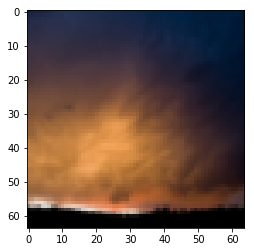

In [105]:
index = 0
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[index]) + ". It's a " + classes[train_y[index]].decode("utf-8") +  " picture.")

In [106]:
train_x = train_x_orig.reshape(train_x_orig.shape[0],-1) / 255 
test_x = test_x_orig.reshape(test_x_orig.shape[0],-1) / 255
print('Train_x\'s shape:{}'.format(train_x.shape))
print('Test_x\'s shape:{}'.format(test_x.shape))
print("Train_y's shape:{}".format(train_y.shape))
print("Test_y's shape:{}".format(test_y.shape))

Train_x's shape:(209, 12288)
Test_x's shape:(50, 12288)
Train_y's shape:(209,)
Test_y's shape:(50,)


### Create Model

在这个例子中我们创建一个**Model**类,用于处理1.Base Lines 2.Regularization 3.Droupout

**函数解释表:**

[1]

```python
def __init__(self,layers,lr,epochs,batch_size,print_step,mode=None):
    ...````
    
初始化类,通过```mode=None```来控制类走1,2,3哪种情况.其中```None```为1.Base Lines.

[2]

```python
def init_parameters(self):
    ...```

通过多个判断条件走不同的mode.在TF中,可以使用两种方式来创建regularization:

(2.1) ```tf.get_variable()```


(2.2) ```tf.Variable()```

这里使用的是(2.1)的形式:

```python

tf.get_variable(
    name,
    shape=None,
    dtype=None,
    initializer=None,
    regularizer=None,
    ...
)```

```python
tf.contrib.layers.l1_regularizer(scale,scope=None)```

其中 scale就是惩罚项$lambda$.

[tf.contrib.layers.l1_regularizer](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/l1_regularizer)



可以看到```tf.get_variable```参数含有```regularizer=None```,那么我们就可以使用一下的方式进行创建


```python
W = tf.get_variable('W'+str(l+1),[self.layers[l],self.layers[l+1]],
                    regularizer=tf.contrib.layers.l1_regularizer(self.lambd),
                    initializer=tf.contrib.layers.xavier_initializer(seed=1))```


于是:```tf.contrib.layers.l1_regularizer(self.lambd)```相当于```tf.reduce_sum(tf.abs(a))*self.lambd```并采用$xavier$初始化.

同样```tf.contrib.layers.l2_regularizer(self.lambd)```相当于```tf.reduce_sum((a*a))*self.lambd/2```并采用$xavier$初始化.

(2.1.1)

获取计算图中的所有REGULARIZATION LOSSES:

```regularizer_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)```

[tf.get_collection(key, scope=None)](https://www.tensorflow.org/api_docs/python/tf/get_collection)用来获取一个名称是'key'的集合中的所有元素,返回的是一个列表,列表的顺序是按照变量放入集合中的先后;scope参数可选,表示的是名称空间(名称域),如果指定,就返回名称域中所有放入'key'的变量的列表,不指定则返回所有变量.

(2.1.2)

将REGULARIZATION LOSSES添加到普通loss中:

```cost += tf.math.add_n(regularizer_loss)```

[tf.add_n(inputs, name=None)](https://www.tensorflow.org/api_docs/python/tf/math/add_n),把所有'inputs'列表中的所有变量值相加,name可选,是操作的名称,这样TF才能更新regularization之后的$W$.



(2.2) 

详情查看[Tensorflow中实现正则化](https://zhuanlan.zhihu.com/p/46605257)


对于Dropout和Base Lines而言,直接使用以前的方式.

[3] 

```python
def forward(self,X,parameters):
    ...```
    
对于Dropout而言,我们需要使用```tf.layers.dropout(inputs,rate=0.5,noise_shape=None,seed=None,training=False,name=None)```其中:

inputs: 上层输出值

rate: 删除节点百分比,是一个小数,相当于```1-keep_prob```.

training: 是否处于训练模式

[tf.layers.dropout](https://www.tensorflow.org/api_docs/python/tf/layers/dropout)


[4]

```python
def fit(self,data,labels,val_data,val_labels,lambd=None,rate=None):
    ...```

    
(4.1) 当我们选择regularization的时候,我们需要:

```python

regularizer_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
            cost += tf.math.add_n(regularizer_loss)```
            
将regularization的loss值加到cost上.

(4.2) 当我们选择dropout的时候,我们需要将```training=True```,在测试的时候需要设置为```training=False```.

In [218]:
class Model:
    """
    Build Regularization Model.
    """
    def __init__(self,layers,lr,epochs,batch_size,print_step,mode=None):
        """
        Initialization class
        Parameters:
        ----------
            layers: hidden layers + output layers units.
            lr: learLearning rate.
            epochs: #Iterate.
            batch_size: batch size.
            print_step: print value in each step.
            mode: 
                can choose 1.None:Base Lines,2.L1 or L2,3.dropout
                default None.
        """
        ops.reset_default_graph()
        self.layers = layers
        self.lr = lr
        self.print_step = print_step
        self.epochs = epochs
        self.batch_size = batch_size
        self.mode = mode
        
        # cache train/validation accuracy , train/validata loss
        self.acc_trains = []
        self.train_losss = []
        self.acc_vals = []
        self.val_losss = []
    
    def init_parameters(self):
        """
        Initialization parameters
        
        Return:
        ------
            parameters: include weights and bias,or L1/L2 weights if running mode is regulation.
        """
        parameters = {}
        for l in range(self.L-1):
            if self.mode == 'l1':
                W = tf.get_variable('W'+str(l+1),[self.layers[l],self.layers[l+1]],
                                   regularizer=tf.contrib.layers.l1_regularizer(self.lambd),
                                   initializer=tf.contrib.layers.xavier_initializer(seed=1))
            elif self.mode == "l2":
                W = tf.get_variable('W'+str(l+1),[self.layers[l],self.layers[l+1]],
                                   regularizer=tf.contrib.layers.l2_regularizer(self.lambd),
                                   initializer=tf.contrib.layers.xavier_initializer(seed=1))
            elif self.mode is None or self.mode == "dropout":
                W = tf.get_variable('W'+str(l+1),[self.layers[l],self.layers[l+1]],
                                   initializer=tf.contrib.layers.xavier_initializer(seed=1))
            else:
                raise ValueError('Invalid model %s'%self.mode)
                
            b = tf.Variable(tf.zeros([1,self.layers[l+1]],name='b'+str(l+1)))
            parameters['W' + str(l+1)] = W
            parameters['b' + str(l+1)] = b
            
        return parameters
            
    
    def forward(self,X,parameters):
        """
        Forward propagation.
        
        Paramters:
        ---------
            X: training data set.
            parameters: weights and bias or L1,L2 weights.
        
        Return:
        ------
            Z: output layer value,notice,it dose not pass activation function.
        
        Note:
        ----
            if mode is dropout, then using tf.layers.dropout. and set training True.
            if in the testing environment，parameter training is False.
        """
        
        A = X
        for l in range(self.L-1):
            W = parameters['W'+str(l+1)]
            b = parameters['b'+str(l+1)]
            Z = tf.add(tf.matmul(A,W),b)
            if l != self.L - 2:
                A = tf.nn.relu(Z)
                if self.mode == "dropout":
                    A = tf.layers.dropout(A,rate=self.rate,training=self.is_training)
            else:
                return Z
            
            
    def fit(self,data,labels,val_data,val_labels,lambd=None,rate=None):
        """
        Fitting Model.
        
        Parameters:
        ----------
            data: training data.
            labels: training labels.
            val_data: validation data.
            val_labels: validation labels.
            lambd: regulation parameter, default None.
            rate: dropout parameter,notice, rate equal 1-keep_prob. means: percent delete units.
        
        Returns:
        -------
            self.train_losss: cache training loss in each step.
            self.acc_trains: cache training correct rate in each step.
            self.val_losss: cache validation data loss in each step.
            self.acc_vals: cache validation data correct rate in each step.
        """
        m,n = data.shape
        self.layers.insert(0,n)
        self.L = len(self.layers)
        self.lambd = lambd
        self.rate = rate
        
        # create place holder.
        X = tf.placeholder(tf.float32,[None,n])
        y = tf.placeholder(tf.float32,[None,1])
        self.is_training = tf.placeholder(tf.bool) # create tensor bool,using dropout layer.
        
        # Initialization parameters.
        parameters = self.init_parameters()
        # start forward
        Z = self.forward(X,parameters)
        # caculate loss
        cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Z,labels=y))
        # add regularization loss in cost value, if use regulation.
        if self.mode == "l1" or self.mode == "l2":
            regularizer_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
            cost += tf.math.add_n(regularizer_loss)
            
        # create optimizer and minimize cost,like backward.  
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.lr).minimize(cost)
        
        # caculate correct rate.
        correct = tf.equal(tf.round(tf.sigmoid(Z)),y)
        accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))
        
        # initialization global variables.
        init = tf.global_variables_initializer()
        
        # start running model.
        with tf.Session() as sess:
            sess.run(init)
            num_batch = m // self.batch_size
            
            seed = 0
            for epoch in range(self.epochs):
                epoch_cost = 0
                seed += 1
                # using minibatch.
                batchs = random_mini_batche(data,labels,seed=seed)
                for mini_X,mini_y in batchs:
                    _,loss = sess.run([optimizer,cost],feed_dict={X:mini_X,y:mini_y.reshape(-1,1),
                                                                 self.is_training:True})
                    epoch_cost += loss / num_batch # caculate average loss in each batch.
                    
                if epoch % self.print_step == 0:
                    # Note:
                    # In the testing environment, must be set self.is_training equal False
                    self.train_losss.append(epoch_cost)
                    acc_train = sess.run(accuracy,feed_dict={X:data,y:labels.reshape(-1,1),
                                                             self.is_training:False})
                    self.acc_trains.append(acc_train)
                    acc_val = sess.run(accuracy,feed_dict={X:val_data,y:val_labels.reshape(-1,1),
                                                           self.is_training:False})
                    self.acc_vals.append(acc_val)
                    val_loss = sess.run(cost,feed_dict={X:val_data,y:val_labels.reshape(-1,1)
                                                       ,self.is_training:False})
                    self.val_losss.append(val_loss)
                    print('[{}/{}] loss:{},acc train:{},val loss:{},acc val:{}'.format(epoch + self.print_step,
                                                                                       self.epochs,
                                                                                       epoch_cost,
                                                                                      acc_train,val_loss,acc_val))
            return self.train_losss,self.acc_trains,self.val_losss,self.acc_vals

### Testing Model

#### Base Lines.

In [221]:
layers = [20,7,5,1]
model = Model(layers=layers,lr=0.01,epochs=500,batch_size=64,print_step=50)

In [222]:
train_losss_bl,acc_trains_bl,val_losss_bl,acc_vals_bl = model.fit(train_x,train_y,test_x,test_y)

[50/500] loss:0.9783182342847188,acc train:0.5167464017868042,val loss:0.6954159736633301,acc val:0.4399999976158142
[100/500] loss:0.7200096944967905,acc train:0.7416267991065979,val loss:0.5888243317604065,acc val:0.800000011920929
[150/500] loss:0.4804572959740957,acc train:0.8851674795150757,val loss:0.5157895088195801,acc val:0.7799999713897705
[200/500] loss:0.27468063433965045,acc train:0.9473684430122375,val loss:0.6778333187103271,acc val:0.7200000286102295
[250/500] loss:0.1383938118815422,acc train:0.980861246585846,val loss:0.830142080783844,acc val:0.7400000095367432
[300/500] loss:0.08169559016823769,acc train:0.9952152967453003,val loss:0.7306175827980042,acc val:0.7799999713897705
[350/500] loss:0.03236288670450449,acc train:1.0,val loss:0.8785854578018188,acc val:0.7799999713897705
[400/500] loss:0.019448414755364258,acc train:1.0,val loss:1.1063282489776611,acc val:0.7400000095367432
[450/500] loss:0.009257753612473607,acc train:1.0,val loss:1.0550446510314941,acc val

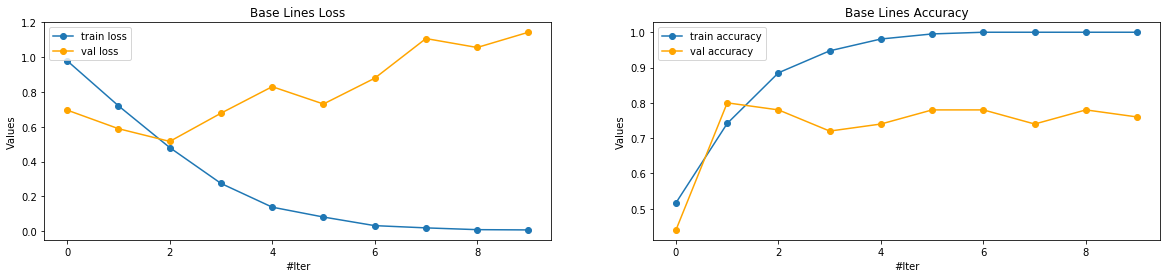

In [223]:
plot_plot(train_losss_bl,acc_trains_bl,acc_vals_bl,val_losss_bl,method='Base Lines')

可以看出,在大约3个epoch的时候,validation data loss 开始上升,此时模型开始过拟合.

#### L1 regularization

先尝试L1正则化,由于L1的作用比较强硬,所以我们不可以设置较大的值.

In [240]:
layers = [20,7,5,1]
model = Model(layers=layers,lr=0.01,epochs=500,batch_size=64,print_step=50,mode='l1')
train_losss_l1,acc_trains_l1,val_losss_l1,acc_vals_l1 = model.fit(train_x,train_y,test_x,test_y,lambd=0.002)

[50/500] loss:8.314722220102947,acc train:0.5167464017868042,val loss:6.173153400421143,acc val:0.4399999976158142
[100/500] loss:5.699607849121094,acc train:0.7751196026802063,val loss:4.332009792327881,acc val:0.7599999904632568
[150/500] loss:3.7377803325653076,acc train:0.8899521827697754,val loss:2.911375045776367,acc val:0.7599999904632568
[200/500] loss:2.3338401317596436,acc train:0.9090909361839294,val loss:1.9308922290802002,acc val:0.7200000286102295
[250/500] loss:1.6873707373936973,acc train:0.6650717854499817,val loss:1.9423716068267822,acc val:0.36000001430511475
[300/500] loss:1.177706281344096,acc train:0.7559808492660522,val loss:0.909376859664917,acc val:0.8399999737739563
[350/500] loss:0.9835047920544941,acc train:0.6411483287811279,val loss:0.8519287109375,acc val:0.7400000095367432
[400/500] loss:1.0592981576919556,acc train:0.9043062329292297,val loss:0.8339090943336487,acc val:0.7400000095367432
[450/500] loss:1.3642060955365498,acc train:0.8181818127632141,val

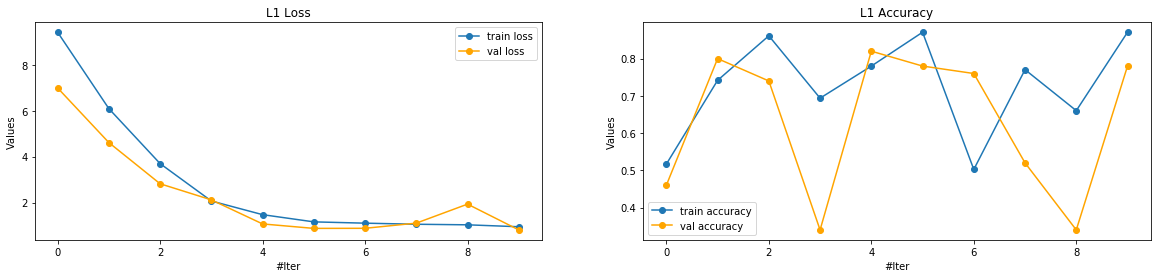

In [239]:
plot_plot(train_losss_l1,acc_trains_l1,acc_vals_l1,val_losss_l1,method='L1')

可以看出,validation data loss 结果有明显的改变,但是正确率有明显的下降,这是必然现象,解决过拟合的模式实际上就是让模型从过拟合向欠拟合的方向行走.

最后的结果可以看出,训练样本的正确率和测试样本的正确率比较近,但是两者的浮动都比较大.

#### L2 regularization

由于L1 regularization太过"刚硬",我们更多情况下选择的是"L2".

In [247]:
layers = [20,7,5,1]
model = Model(layers=layers,lr=0.01,epochs=500,batch_size=64,print_step=50,mode='l2')
train_losss_l2,acc_trains_l2,val_losss_l2,acc_vals_l2 = model.fit(train_x,train_y,test_x,test_y,lambd=0.15)

[50/500] loss:6.85905122756958,acc train:0.5263158082962036,val loss:5.073193550109863,acc val:0.4399999976158142
[100/500] loss:4.073504686355591,acc train:0.6698564887046814,val loss:3.1376678943634033,acc val:0.3400000035762787
[150/500] loss:2.5919112364451093,acc train:0.6937798857688904,val loss:2.1788012981414795,acc val:0.3799999952316284
[200/500] loss:1.7740368843078613,acc train:0.7224880456924438,val loss:1.6266696453094482,acc val:0.4000000059604645
[250/500] loss:1.405738592147827,acc train:0.679425835609436,val loss:1.4630916118621826,acc val:0.3799999952316284
[300/500] loss:1.1291411519050598,acc train:0.8373205661773682,val loss:1.1360527276992798,acc val:0.5799999833106995
[350/500] loss:0.9957866668701172,acc train:0.8947368264198303,val loss:0.8919234275817871,acc val:0.8199999928474426
[400/500] loss:0.9746753970781962,acc train:0.9282296895980835,val loss:0.9055469036102295,acc val:0.699999988079071
[450/500] loss:0.949524203936259,acc train:0.9377990365028381,va

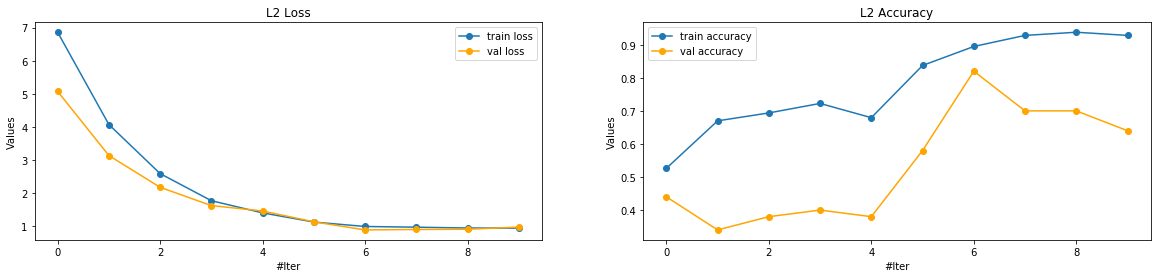

In [248]:
plot_plot(train_losss_l2,acc_trains_l2,acc_vals_l2,val_losss_l2,method='L2')

可以看出"L2"的效果要温柔于"L1",且在$\lambda=0.15$的情况下,我们选择大约350epochs效果最好.

#### Dropout 

Dropout 通过随机停止百分比的神经元来使得模型变得更加简单,从而解决过拟合.

In [256]:
layers = [20,7,5,1]
model = Model(layers=layers,lr=0.01,epochs=500,batch_size=64,print_step=50,mode='dropout')
train_losss_dp,acc_trains_dp,val_losss_dp,acc_vals_dp = model.fit(train_x,train_y,test_x,test_y,rate=0.2)

[50/500] loss:0.9606479803721109,acc train:0.6267942786216736,val loss:0.7200927734375,acc val:0.41999998688697815
[100/500] loss:0.8845118284225464,acc train:0.6555023789405823,val loss:0.7203349471092224,acc val:0.3400000035762787
[150/500] loss:0.7626357078552247,acc train:0.6555023789405823,val loss:0.8522063493728638,acc val:0.3400000035762787
[200/500] loss:0.6996294558048248,acc train:0.660287082195282,val loss:0.8696036338806152,acc val:0.3400000035762787
[250/500] loss:0.6661939223607382,acc train:0.7081339955329895,val loss:0.7187126874923706,acc val:0.47999998927116394
[300/500] loss:0.7220052778720856,acc train:0.8516746163368225,val loss:0.6905620694160461,acc val:0.6000000238418579
[350/500] loss:0.47737551728884375,acc train:0.8516746163368225,val loss:0.5171167850494385,acc val:0.8199999928474426
[400/500] loss:0.480672021706899,acc train:0.9569377899169922,val loss:0.7125157713890076,acc val:0.7200000286102295
[450/500] loss:0.45905157923698425,acc train:0.971291840076

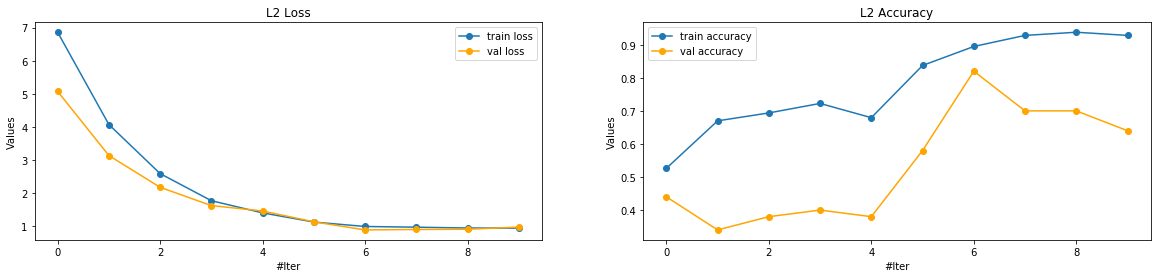

In [251]:
plot_plot(train_losss_l2,acc_trains_l2,acc_vals_l2,val_losss_l2,method='L2')

可以看到Dropout解决过拟合是比较好的方法,rate越大,那么模型就越简单,越容易欠拟合.

从中可以看出也是大约在350epochs的时候,效果最好.

# Summary

(1) 在tensorflow中,我们如果要使用正则化,则需要在初始化权重的时候加入regularization参数,并且在计算loss的时候要将计算图中的regularization loss加入在基本loss中.

(2) 其实我们在一般情况下更愿意使用L2,而不是L1.

(3) 对于Dropout而言,训练的时候我们要将参数training打开,但是在测试阶段,我们需要关闭参数training,因为如果在测试阶段使用Dropout,那么模型将会处于一种不稳定状态.

(4) 不是说使用Regularization/Dropout就能起到完全解决过拟合的状态(即train/validation correct rate极度相近,也就是处于"Best"),两者只是一个优化方法,能够减缓模型过拟合.